['Platform',
 'subjectNo',
 'normTime',
 'jumpNo',
 'lmg_airsum',
 'lmg_lsrsum',
 'rmg_airsum',
 'rmg_lsrsum',
 'lta_airsum',
 'lta_lsrsum',
 'rta_airsum',
 'rta_lsrsum',
 'lmg_iemg_air',
 'rmg_iemg_air',
 'lta_iemg_air',
 'rta_iemg_air',
 'lmg_iemg_lnd',
 'rmg_iemg_lnd',
 'lta_iemg_lnd',
 'rta_iemg_lnd',
 'F1',
 'T1',
 'W1',
 'F2',
 'T2',
 'W2',
 'F3',
 'T3',
 'W3',
 'F2F1',
 'bmg_wav']

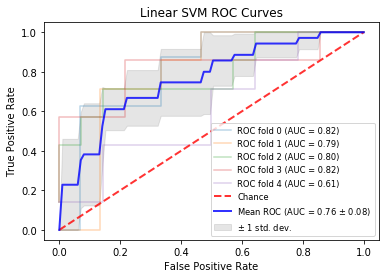

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# load data ~/dropbox/nasa_stretch/force_features/force_emg_expl.csv

df = pd.read_csv('~/dropbox/nasa_stretch/force_features/force_emg_expl.csv')

# add ratios

df = df.assign(bmg_wav=(df['lmg_airsum'] + df['rmg_airsum'])/(df['lmg_lsrsum'] + df['rmg_lsrsum']),
               bmg_iemg=(df['lmg_iemg_air'] + df['rmg_iemg_air'])/(df['lmg_iemg_lnd'] + df['rmg_iemg_lnd']),
               bta_wav=(df['lta_airsum'] + df['rta_airsum'])/(df['lta_lsrsum'] + df['rta_lsrsum']),
               bta_iemg=(df['lta_iemg_air'] + df['rta_iemg_air'])/(df['lta_iemg_lnd'] + df['rta_iemg_lnd']))

# reorder for i/o paradigm
df = df[['Platform',
 'subjectNo',
 'normTime',
 'jumpNo',
 'lmg_airsum',
 'lmg_lsrsum',
 'rmg_airsum',
 'rmg_lsrsum',
 'lta_airsum',
 'lta_lsrsum',
 'rta_airsum',
 'rta_lsrsum',
 'lmg_iemg_air',
 'rmg_iemg_air',
 'lta_iemg_air',
 'rta_iemg_air',
 'lmg_iemg_lnd',
 'rmg_iemg_lnd',
 'lta_iemg_lnd',
 'rta_iemg_lnd',
 'bmg_wav',
 'bmg_iemg',
 'bta_wav',
 'bta_iemg',
 'F1',
 'T1',
 'W1',
 'F2',
 'T2',
 'W2',
 'F3',
 'T3',
 'W3',
 'F2F1']]

# remove cases where jumpNo > 3

df = df[df.jumpNo <= 3]

# get ISS platform
df_plats = df.groupby('Platform')
df_iss = df_plats.get_group('ISS')

a_iss = df_iss['normTime'] == "A"
b_iss = df_iss['normTime'] == "B"
c_iss = df_iss['normTime'] == "C"
e_iss = df_iss['normTime'] == "E"
f_iss = df_iss['normTime'] == "F"
g_iss = df_iss['normTime'] == "G"

c_e_iss = df_iss[c_iss | e_iss]


# define data sets and target vectors for classification
c_e_iss_predictors = c_e_iss.loc[:, 'lmg_airsum':'bta_iemg']
c_e_iss_F2F1 = c_e_iss['F2F1']

X = c_e_iss_predictors[['bta_iemg', 'bmg_iemg']]
y = c_e_iss['normTime']  # need categories for SVC, may need c and e.

X = X.as_matrix()
y = y.as_matrix()

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

cv = StratifiedKFold(n_splits=5)

random_state = np.random.RandomState(0)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state, C=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0 
for train, test in cv.split(X, y):
    # print(X[test])
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.5, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC Curves')
plt.legend(loc="lower right", fontsize='small')
# plt.show()
plt.savefig('/Users/robertstallard/Dropbox/NASA_stretch/JDT-ML/graphics/roc_linear_svc_5fold.png', dpi=350, bbox='tight')

In [129]:
a_iss = df_iss['normTime'] == "A"
b_iss = df_iss['normTime'] == "B"
c_iss = df_iss['normTime'] == "C"
e_iss = df_iss['normTime'] == "E"
f_iss = df_iss['normTime'] == "F"
g_iss = df_iss['normTime'] == "G"

c_e_iss = df_iss[c_iss | e_iss]

le = preprocessing.LabelEncoder()
# define data sets and target vectors for classification
c_e_iss_predictors = c_e_iss.loc[:, 'lmg_airsum':'bta_iemg']
c_e_iss_F2F1 = c_e_iss['F2F1']

X = c_e_iss_predictors[['bta_iemg', 'bmg_iemg']]
y = c_e_iss['normTime']  # need categories for SVC, may need c and e.
y = y.as_matrix()
type(y)
y
le.fit(y)
le.get_params()
le.transform(y)



array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])